# Week 5A: More Geospatial Analysis: Urban Networks

- Monday, October 2, 2023
- Section 401

In [3]:
# The usual imports
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
# Show all columns in dataframes
pd.options.display.max_columns = 999

In [5]:
# Hide warnings due to issue in shapely package 
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");

## Today: Urban street networks and OpenStreetMap (OSM)

- Two tools that make working with OSM data very easy
- What kind of questions can we answer?
    - Street orientations 
    - Mapping event points to streets: car crashes
    - Mapping amenities
    - Network-constrained distances: accessibility

## OSM: what is it?

- Collaborative mapping
- A free editable map of the World
- Sort of like Wikipedia for maps

**Great source of data: street networks and a wealth of amenity information**

https://www.openstreetmap.org

## Working with OSM data

- Raw data is very messy
- Two relatively new, amazing Python packages greatly simply the process
- Related, but complementary features    
    - **OSMnx:** downloading and manipulating streets as networks
    - **Pandana:** networks focused on accessibility of amenities
    
**Related:** interactive web maps in Python

## Part 1: OSMnx

Relatively new package (just a few years old), but quickly becoming the go to package for working with street networks and OpenStreetMap data in Python.

Several key features: 

- Downloading political boundaries for cities, states, countries, etc
- Downloading street networks
- Analyzing networks: routing, visualization, statistics

  - [GitHub](https://github.com/gboeing/osmnx)
  - [Introductory Blog Post](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Jupyter Notebook Examples](https://github.com/gboeing/osmnx-examples/tree/master/notebooks) ([Binder](https://mybinder.org/v2/gh/gboeing/osmnx-examples/main?urlpath=/tree/notebooks))
  - [Documentation](https://osmnx.readthedocs.io)

In [6]:
import osmnx as ox

### 1.1. Getting boundary shapefiles from OSM

Key function: `geocode_to_gdf()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.geocoder.geocode_to_gdf))

We can get the boundary for anything identified as a "place" by OSM.

**Important: Be careful to pass the right place name that OSM needs**

In [7]:
philly = ox.geocode_to_gdf("Philadelphia, PA")
philly.head()

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-75.28030 39.97500, -75.28022 39.974...",40.137959,39.867005,-74.955831,-75.280298,14128726,relation,188022,39.952724,-75.163526,boundary,administrative,16,0.713797,city,Philadelphia,"Philadelphia, Pennsylvania, United States"


In [8]:
philly.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can plot it just like any other GeoDataFrame

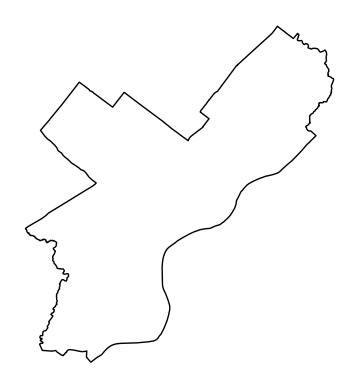

In [9]:
# Project it to Web Mercator first and plot
ax = philly.to_crs(epsg=3857).plot(facecolor="none", edgecolor="black")
ax.set_axis_off()

### 1.2 Projecting with OSMnx

Key function: `project_gdf()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_gdf))

Automatically projects to the [Universal Transverse Mercator](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) (UTM) CRS for the UTM zone that the centroid of the polygon lies in 

A good, general projection that works for most latitudes except very northern locations.

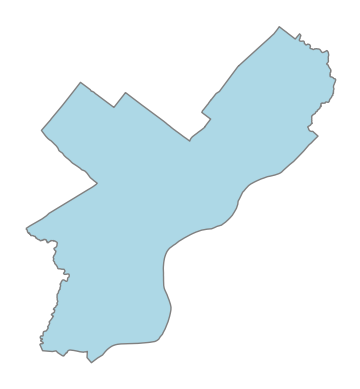

In [10]:
ax = ox.project_gdf(philly).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

Some more examples:

In [11]:
# Some examples
place1 = ox.geocode_to_gdf("Manhattan, New York City, New York, USA")
place2 = ox.geocode_to_gdf("Miami-Dade County, Florida")
place3 = ox.geocode_to_gdf("Florida, USA")
place4 = ox.geocode_to_gdf("Spain")

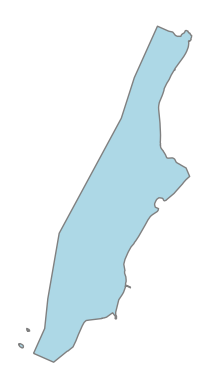

In [12]:
# Manhattan
ax = ox.project_gdf(place1).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

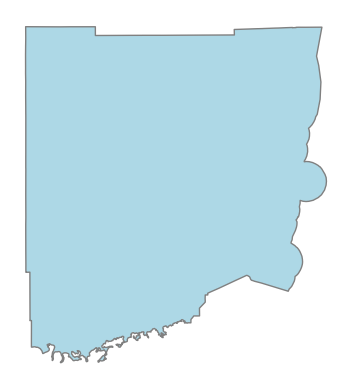

In [13]:
# Miami-Dade County
ax = ox.project_gdf(place2).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

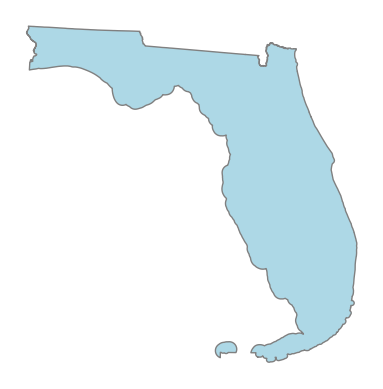

In [14]:
# Florida
ax = ox.project_gdf(place3).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

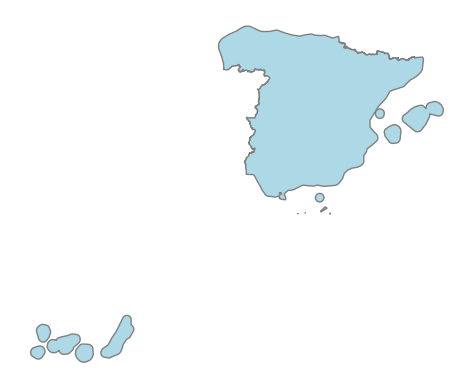

In [15]:
# Spain
ax = ox.project_gdf(place4).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

### 1.3 Downloading OSM features

Key functions: `features_from_*`

- `features_from_place()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_place))
     - Download features within an OSM place boundary
- `features_from_address()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_address))
    - Download features within a certain distance of an address
- `features_from_bbox()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_bbox))
    - Download features within a N, S, E, W bounding box
- `features_from_point()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_point)) 
    - Download features within a certain distance of a specified point
- `features_from_polygon()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.features.features_from_polygon))
    - Download features within a polygon object

::: {.callout-note}
### About OSM features

**Important reference:** https://wiki.openstreetmap.org/wiki/Map_Features

- OSM uses a *tagging* system to categorize different map features
- The main feature categories are available on the OSM Wikipedia
    - Examples: 'amenity', 'building', 'landuse', 'highway'
- There are specific sub-categories for each feature type too:
    - Amenity examples: 'bar', 'college', 'library'

In the language of OSM, the "key" is the main feature category (e.g., amenity) and the "value" is the sub-category type (e.g., "bar")
:::

`osmnx` mirrors the key/value syntax of OSM. Use a dict to specify the features you want: 

In [16]:
# Get all amenities in Philadelphia
amenities = ox.features_from_place("Philadelphia, PA", tags={"amenity": True})

In [17]:
len(amenities)

10681

In [18]:
amenities.head()

geometry      amenity  \
element_type osmid                                                
node         109811385  POINT (-75.19487 40.05846)        bench   
             274215467  POINT (-75.19492 39.95935)    fast_food   
             274216093  POINT (-75.19125 39.95764)          atm   
             274217596  POINT (-75.19229 39.95301)         cafe   
             313440966  POINT (-75.16694 39.96394)  car_sharing   

                            created_by      cuisine            name  \
element_type osmid                                                    
node         109811385             NaN          NaN             NaN   
             274215467   Potlatch 0.9c        pizza  Powelton Pizza   
             274216093             NaN          NaN        Citibank   
             274217596             NaN  coffee_shop       Starbucks   
             313440966  Potlatch 0.10f          NaN             NaN   

                            brand brand:wikidata brand:wikipedia  operator  \
element_type osmid                                                           
node         109811385        NaN            NaN             NaN       NaN   
             274215467        NaN            NaN             NaN       NaN   
             274216093   Citibank        Q857063     en:Citibank  Citibank   
             274217596  Starbucks         Q37158    en:Starbucks       NaN   
             313440966        NaN            NaN             NaN       NaN   

                       operator:wikidata operator:wikipedia short_name  \
element_type osmid                                                       
node         109811385               NaN                NaN        NaN   
             274215467               NaN                NaN        NaN   
             274216093           Q857063        en:Citibank       Citi   
             274217596               NaN                NaN        NaN   
             313440966               NaN                NaN        NaN   

                           addr:city addr:housenumber addr:postcode  \
element_type osmid                                                    
node         109811385           NaN              NaN           NaN   
             274215467           NaN              NaN           NaN   
             274216093           NaN              NaN           NaN   
             274217596  Philadelphia             3401         19104   
             313440966           NaN              NaN           NaN   

                       addr:state    addr:street  \
element_type osmid                                 
node         109811385        NaN            NaN   
             274215467        NaN            NaN   
             274216093        NaN            NaN   
             274217596         PA  Walnut Street   
             313440966        NaN            NaN   

                                                          contact:website  \
element_type osmid                                                          
node         109811385                                                NaN   
             274215467                                                NaN   
             274216093                                                NaN   
             274217596  https://www.starbucks.com/store-locator/store/...   
             313440966                                                NaN   

                           official_name  \
element_type osmid                         
node         109811385               NaN   
             274215467               NaN   
             274216093               NaN   
             274217596  Starbucks Coffee   
             313440966               NaN   

                                               opening_hours         phone  \
element_type osmid                                                           
node         109811385                                   NaN           NaN   
             274215467                                   NaN  

In [19]:
# Get all bars in philadelphia
bars = ox.features_from_place("Philadelphia, PA", tags={"amenity": "bar"})

In [20]:
len(bars)

166

In [21]:
bars.head()

addr:city addr:housenumber addr:postcode  \
element_type osmid                                                     
node         357303425   Philadelphia              500         19123   
             655425272            NaN              NaN           NaN   
             1033935437           NaN             2101           NaN   
             1167079387           NaN              401           NaN   
             1204761128           NaN              NaN           NaN   

                        addr:state           addr:street amenity brewery  \
element_type osmid                                                         
node         357303425          PA  Spring Garden Street     bar     yes   
             655425272         NaN                   NaN     bar     NaN   
             1033935437        NaN       Chestnut Street     bar     NaN   
             1167079387        NaN          South Street     bar     NaN   
             1204761128        NaN                   NaN     bar     NaN   

                           craft gnis:county_id microbrewery  \
element_type osmid                                             
node         357303425   brewery            101          yes   
             655425272       NaN            NaN          NaN   
             1033935437      NaN            NaN          NaN   
             1167079387      NaN            NaN          NaN   
             1204761128      NaN            NaN          NaN   

                                             name               operator  \
element_type osmid                                                         
node         357303425      Yards Brewing Company  Yards Brewing Company   
             655425272              Drinkers West                    NaN   
             1033935437           Mix Bar & Grill                    NaN   
             1167079387      MilkBoy South Street                    NaN   
             1204761128  Vikings High School Club                    NaN   

                        restaurant                    website   wikidata  \
element_type osmid                                                         
node         357303425         yes  https://yardsbrewing.com/  Q16903914   
             655425272         NaN                        NaN        NaN   
             1033935437        NaN                        NaN        NaN   
             1167079387        NaN                        NaN        NaN   
             1204761128        NaN                        NaN        NaN   

                                        wikipedia                    geometry  \
element_type osmid                                                              
node         357303425   en:Yards Brewing Company  POINT (-75.14712 39.96067)   
             655425272                        NaN  POINT (-75.20020 39.95521)   
             1033935437                       NaN  POINT (-75.17552 39.95242)   
             1167079387                       NaN  POINT (-75.14925 39.94170)   
             1204761128                       NaN  POINT (-75.16363 39.92685)   

                           contact:phone  \
element_type osmid                         
node         357303425               NaN   
             655425272               NaN   
             1033935437  +1 215-568-3355   
             1167079387  +1 215-925-6455   
             1204761128              NaN   

                                                           contact:website  \
element_type osmid                                                           
node         357303425                                                 NaN   
             655425272                                                 NaN   
             1033935437  https://mixbarandgrillphilly.com/location/mix-...   
             1167079387                 https://www.milkboy.tv/southstreet   
             1204761128                                                NaN   

                                                   

In [22]:
# Get bar, pub, and restaurant features in Philadelphia
food_and_drink = ox.features_from_place(
    "Philadelphia, PA", tags={"amenity": ["pub", "bar", "restaurant"]}
)

In [23]:
len(food_and_drink)

1078

In [24]:
food_and_drink.head()

amenity      created_by  \
element_type osmid                                   
node         333786044  restaurant  Potlatch 0.10f   
             343293806         pub             NaN   
             357303425         bar             NaN   
             566683522  restaurant             NaN   
             596230881  restaurant             NaN   

                                                    name     source  \
element_type osmid                                                    
node         333786044               Sam's Morning Glory  knowledge   
             343293806               Prohibition Taproom     survey   
             357303425             Yards Brewing Company        NaN   
             566683522  Spring Garden Pizza & Restaurant        NaN   
             596230881                               NaN        NaN   

                       wheelchair                    geometry     addr:city  \
element_type osmid                                                            
node         333786044    limited  POINT (-75.15893 39.94086)           NaN   
             343293806        NaN  POINT (-75.15946 39.96073)  Philadelphia   
             357303425        NaN  POINT (-75.14712 39.96067)  Philadelphia   
             566683522        NaN  POINT (-75.15755 39.96205)           NaN   
             596230881        NaN  POINT (-75.18682 40.05492)           NaN   

                       addr:housenumber addr:postcode addr:state  \
element_type osmid                                                 
node         333786044              NaN           NaN        NaN   
             343293806              501         19123         PA   
             357303425              500         19123         PA   
             566683522              NaN           NaN        NaN   
             596230881              NaN           NaN        NaN   

                                 addr:street brewery      opening_hours  \
element_type osmid                                                        
node         333786044                   NaN     NaN                NaN   
             343293806     North 13th Street     yes  Mo-Su 11:00-02:00   
             357303425  Spring Garden Street     yes                NaN   
             566683522                   NaN     NaN                NaN   
             596230881                   NaN     NaN                NaN   

                          craft gnis:county_id microbrewery  \
element_type osmid                                            
node         333786044      NaN            NaN          NaN   
             343293806      NaN            NaN          NaN   
             357303425  brewery            101          yes   
             566683522      NaN            NaN          NaN   
             596230881      NaN            NaN          NaN   

                                     operator restaurant  \
element_type osmid                                         
node         333786044                    NaN        NaN   
             343293806                    NaN        NaN   
             357303425  Yards Brewing Company        yes   
             566683522                    NaN        NaN   
             596230881                    NaN        NaN   

                                          website   wikidata  \
element_type osmid                                             
node         333786044                        NaN        NaN   
             343293806                        NaN        NaN   
             357303425  https://yardsbrewing.com/  Q16903914   
             566683522                        NaN        NaN   
             596230881                        NaN        NaN   

                                       wikipedia cuisine outdoor_seating  \
element_type osmid                                                         
node         333786044                       NaN     NaN             NaN   
             343293806                       NaN     

In [25]:
# Get bus stop features
bus_stops = ox.features_from_place("Philadelphia, PA", tags={"highway": "bus_stop"})

In [26]:
len(bus_stops)

290

In [27]:
bus_stops.head()

bench  bus covered   highway  \
element_type osmid                                     
node         361011456    yes  yes     yes  bus_stop   
             750281693    NaN  yes     NaN  bus_stop   
             768271130    NaN  yes     NaN  bus_stop   
             1015342921   NaN  yes     NaN  bus_stop   
             1015342926   NaN  yes     NaN  bus_stop   

                                                      name network  \
element_type osmid                                                   
node         361011456                 13th St & Market St   SEPTA   
             750281693                                 NaN     NaN   
             768271130   Wissahickon Transportation Center   SEPTA   
             1015342921                                NaN     NaN   
             1015342926                                NaN     NaN   

                        network:wikidata operator public_transport shelter  \
element_type osmid                                                           
node         361011456          Q2037863    SEPTA         platform     yes   
             750281693               NaN      NaN         platform     NaN   
             768271130          Q2037863    SEPTA         platform     yes   
             1015342921              NaN      NaN         platform     NaN   
             1015342926              NaN      NaN         platform     NaN   

                                           geometry network:wikipedia  ref  \
element_type osmid                                                           
node         361011456   POINT (-75.16166 39.95223)               NaN  NaN   
             750281693   POINT (-75.07732 40.01797)               NaN  NaN   
             768271130   POINT (-75.20726 40.01487)               NaN  NaN   
             1015342921  POINT (-75.18187 39.96640)               NaN  NaN   
             1015342926  POINT (-75.18024 39.96670)               NaN  NaN   

                        tactile_paving wheelchair route_ref local_ref  \
element_type osmid                                                      
node         361011456             NaN        NaN       NaN       NaN   
             750281693             NaN        NaN       NaN       NaN   
             768271130             NaN        NaN       NaN       NaN   
             1015342921            NaN        NaN       NaN       NaN   
             1015342926            NaN        NaN       NaN       NaN   

                        designation source  bin  lit departures_board  \
element_type osmid                                                      
node         361011456          NaN    NaN  NaN  NaN              NaN   
             750281693          NaN    NaN  NaN  NaN              NaN   
             768271130          NaN    NaN  NaN  NaN              NaN   
             1015342921         NaN    NaN  NaN  NaN              NaN   
             1015342926         NaN    NaN  NaN  NaN              NaN   

                        internet_access addr:street route_ref_1 description  \
element_type osmid                                                            
node         361011456              NaN         NaN         NaN         NaN   
             750281693              NaN         NaN         NaN         NaN   
             768271130              NaN         NaN         NaN         NaN   
             1015342921             NaN         NaN         NaN         NaN   
             1015342926             NaN         NaN         NaN         NaN   

                        note operator:wikidata brand brand:wikidata railway  \
element_type osmid                                                            
node         361011456   NaN               NaN   NaN            NaN     NaN   
             750281693   NaN               NaN   NaN            NaN     NaN   
             768271130   NaN               NaN   NaN            NaN     NaN   
             1015342921  NaN               NaN   NaN            NaN     N

In [28]:
# Get commercial and retail landuse features
landuse = ox.features_from_place(
    "Philadelphia, PA", tags={"landuse": ["commercial", "retail"]}
)

In [29]:
len(landuse)

349

Let's plot the land use features:

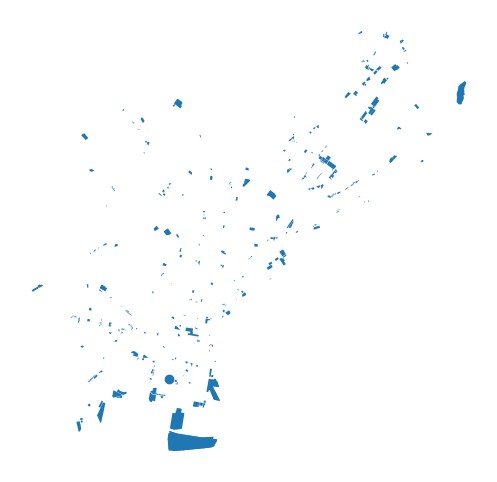

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = landuse.plot(ax=ax)
ax.set_axis_off()

### 1.4 Downloading street networks

Key functions: `graph_from_*` 

- `graph_from_place()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_place))
     - Download street network within an OSM place boundary
- `graph_from_address()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_address))
    - Download street network within a certain distance of an address
- `graph_from_bbox()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_bbox))
    - Download street network within a N, S, E, W bounding box
- `graph_from_point()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_point)) 
    - Download street network within a certain distance of a specified point
- `graph_from_polygon()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_polygon))
    - Download street network within a polygon object

#### Street network around an address

Get streets within 500 meters of the center of Center City

In [31]:
G = ox.graph_from_address("Center City, Philadelphia, PA", dist=500)

Project and plot it:

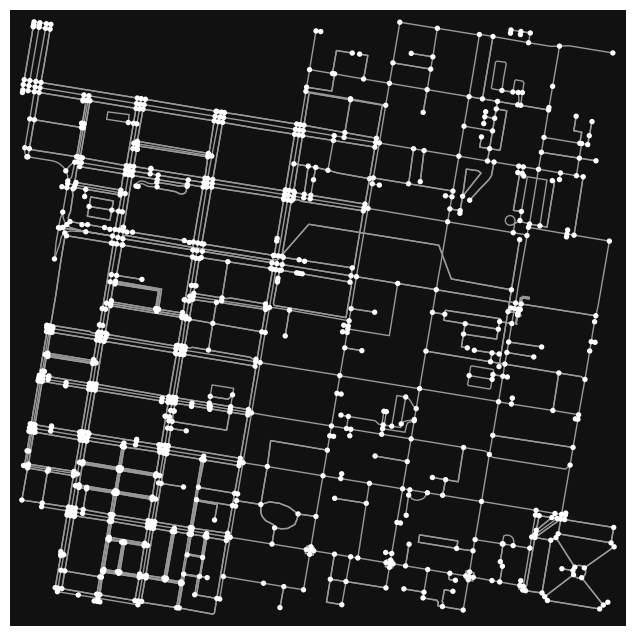

In [32]:
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected);

Remove the nodes:

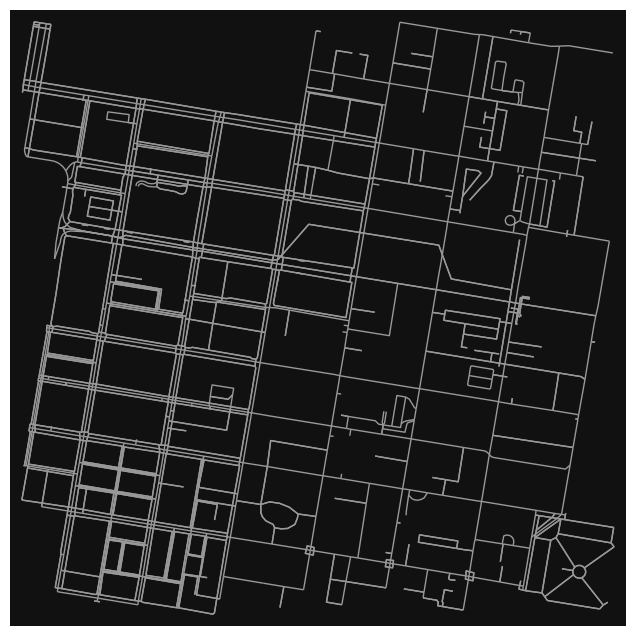

In [33]:
ox.plot_graph(G_projected, node_size=0);

Let's zoom out to 2,000 meters. This will take a little longer.

In [34]:
G = ox.graph_from_address("Center City, Philadelphia, PA", dist=2000)
G_projected = ox.project_graph(G)

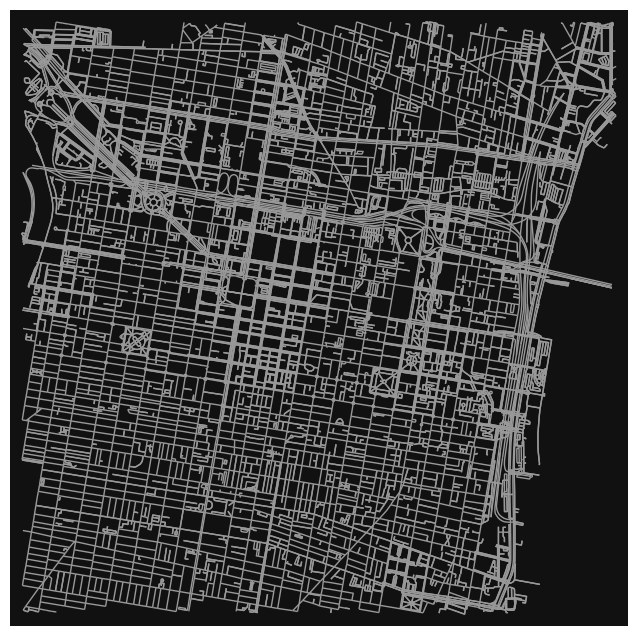

In [35]:
ox.plot_graph(G_projected, node_size=0);

#### Getting different network types

- `drive` - get drivable public streets (but not service roads)
- `drive_service` - get drivable streets, including service roads
- `walk` - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
- `bike` - get all streets and paths that cyclists can use
- `all` - download all non-private OSM streets and paths
- `all_private` - download all OSM streets and paths, including private-access ones (default)

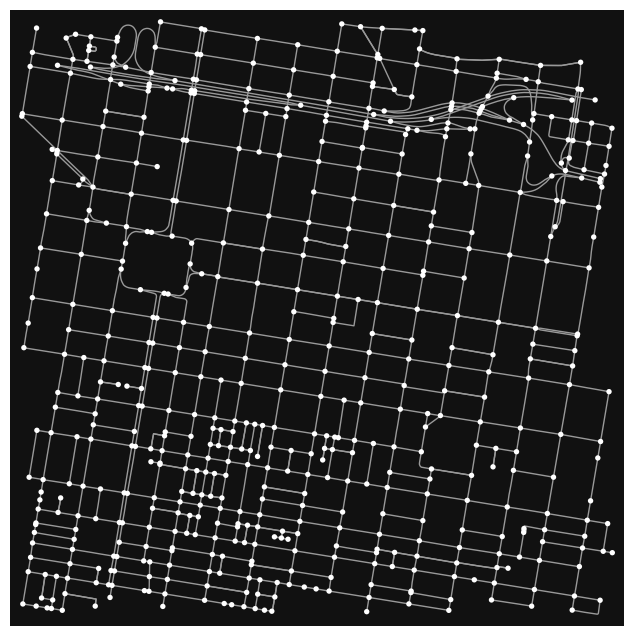

In [36]:
# the "drive" network
G = ox.graph_from_address("Center City, Philadelphia, PA", network_type="drive")
ox.plot_graph(G);

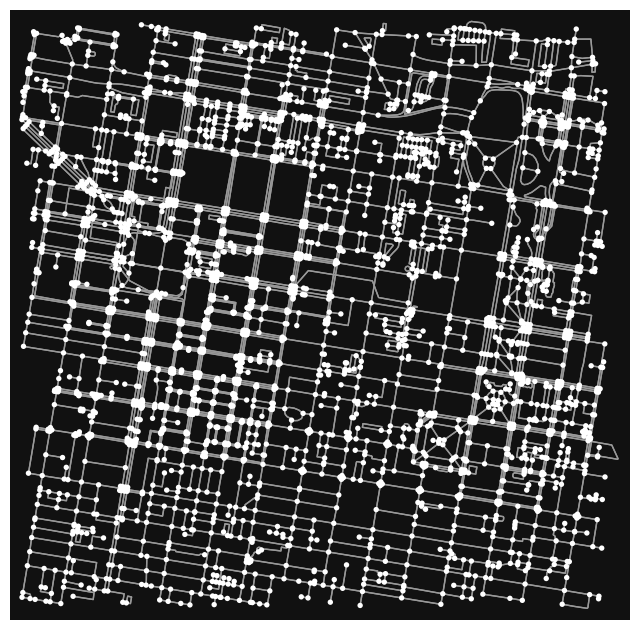

In [37]:
# the "walk" network
G = ox.graph_from_address("Center City, Philadelphia, PA", network_type="walk")
ox.plot_graph(ox.project_graph(G));

#### Street network within a place boundary

Use `graph_from_place()` to get the streets within a specific OSM place.

::: {.callout-caution}

A couple of things to watch out for: 
1. The place query has to be resolved by OSM.
2. If the place is a big city, you might be downloading a lot of data!

:::

Let's check out the street network for Berkeley, CA:

#### Streets within a specific polygon

**Example:** Let's download all streets within Center City. We will use the "Central" planning district as a proxy for this area. The city's planning districts are available on [Open Data Philly](https://opendataphilly.org/datasets/planning-districts/).

In [38]:
planning_districts = gpd.read_file(
    "https://opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson"
)

In [39]:
planning_districts.head(20)

,OBJECTID_1,OBJECTID,DIST_NAME,ABBREV,Shape__Area,Shape__Length,PlanningDist,DaytimePop,geometry
0,1,14,River Wards,RW,2.107270e+08,66931.595020,NaN,NaN,"POLYGON ((-75.09798 40.00496, -75.09687 40.005..."
1,2,3,North Delaware,NDEL,2.700915e+08,89213.074378,NaN,NaN,"POLYGON ((-74.98159 40.05363, -74.98139 40.053..."
2,3,0,Lower Far Northeast,LFNE,3.068529e+08,92703.285159,NaN,NaN,"POLYGON ((-74.96443 40.11728, -74.96434 40.117..."
3,4,9,Central,CTR,1.782880e+08,71405.143450,NaN,NaN,"POLYGON ((-75.14791 39.96733, -75.14715 39.967..."
4,5,10,University Southwest,USW,1.296468e+08,65267.676141,NaN,NaN,"POLYGON ((-75.18742 39.96338, -75.18644 39.963..."
5,6,17,Upper Northwest,UNW,2.851603e+08,82109.452088,NaN,NaN,"POLYGON ((-75.20629 40.08296, -75.20415 40.081..."
6,7,18,Upper North,UNO,2.227549e+08,74155.453511,NaN,NaN,"POLYGON ((-75.15584 40.07274, -75.15470 40.072..."
7,8,8,South,STH,1.748206e+08,65197.355636,NaN,NaN,"POLYGON ((-75.19461 39.94217, -75.19443 39.942..."
8,9,15,North,NOR,2.394755e+08,75031.769136,NaN,NaN,"POLYGON ((-75.10969 40.02217, -75.10937 40.022..."
9,10,16,Lower Northwest,LNW,2.585253e+08,88665.925954,NaN,NaN,"POLYGON ((-75.21379 40.04911, -75.21378 40.049..."


Trim to the central district:

In [40]:
UniversitySW = planning_districts.query("DIST_NAME == 'University Southwest'")

And plot it:

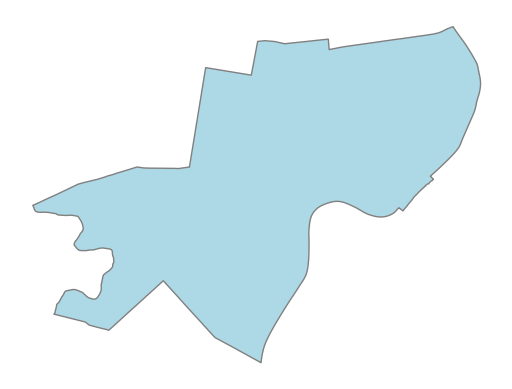

In [41]:
ax = ox.project_gdf(UniversitySW).plot(fc="lightblue", ec="gray")
ax.set_axis_off()

Squeeze it so we can get the geometry polygon:

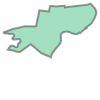

In [42]:
UniversitySW_outline = UniversitySW.squeeze().geometry

UniversitySW_outline

Now, let's use `ox.graph_from_polygon()` to extract streets within this polygon. 

In [43]:
# Get the graph
G_UniversitySW = ox.graph_from_polygon(UniversitySW_outline, network_type="drive")

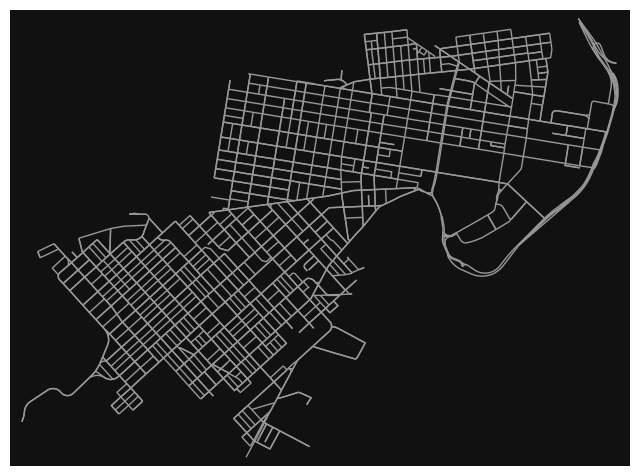

In [44]:
# Viola!
ox.plot_graph(ox.project_graph(G_UniversitySW), node_size=0);

### 1.5 Converting from a graph to a GeoDataFrame

Key function: `ox.graph_to_gdfs()` ([docs](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=graph_to_gdf#osmnx.utils_graph.graph_to_gdfs))

You can get a GeoDataFrame for both the nodes (points) and edges (lines)

In [45]:
type(G_UniversitySW)

networkx.classes.multidigraph.MultiDiGraph

In [46]:
# only get the edges
UniversitySW_edges = ox.graph_to_gdfs(G_UniversitySW, edges=True, nodes=False)

In [47]:
# we have lots of data associated with each edge!
UniversitySW_edges.head()

osmid               name      highway  oneway  \
u         v         key                                                      
109729049 110395837 0     12177237  South 53rd Street  residential   False   
          110395805 0     12177237  South 53rd Street  residential   False   
109729056 109729049 0     12109142    Hadfield Street  residential    True   
          110036974 0    858930075  South 54th Street  residential   False   
          110036982 0    858930075  South 54th Street  residential   False   

                        reversed   length  \
u         v         key                     
109729049 110395837 0      False   63.895   
          110395805 0       True   61.947   
109729056 109729049 0      False  158.613   
          110036974 0      False   51.815   
          110036982 0       True   61.925   

                                                                  geometry  \
u         v         key                                                      
109729049 110395837 0    LINESTRING (-75.22731 39.94551, -75.22698 39.9...   
          110395805 0    LINESTRING (-75.22731 39.94551, -75.22745 39.9...   
109729056 109729049 0    LINESTRING (-75.22868 39.94454, -75.22731 39.9...   
          110036974 0    LINESTRING (-75.22868 39.94454, -75.22909 39.9...   
          110036982 0    LINESTRING (-75.22868 39.94454, -75.22818 39.9...   

                        lanes maxspeed bridge  ref tunnel access  
u         v         key                                           
109729049 110395837 0     NaN      NaN    NaN  NaN    NaN    NaN  
          110395805 0     NaN      NaN    NaN  NaN    NaN    NaN  
109729056 109729049 0     NaN      NaN    NaN  NaN    NaN    NaN  
          110036974 0     NaN      NaN    NaN  NaN    NaN    NaN  
          110036982 0     NaN      NaN    NaN  NaN    NaN    NaN

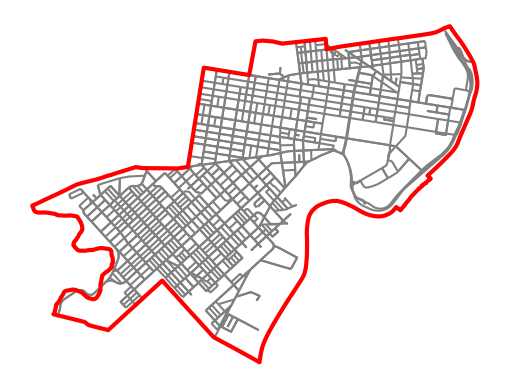

In [48]:
# plot it like any old GeoDataFrame
ax = UniversitySW_edges.to_crs(epsg=3857).plot(color="gray")

# add the neighborhood boundaries
boundary = gpd.GeoSeries([UniversitySW_outline], crs="EPSG:4326")
boundary.to_crs(epsg=3857).plot(
    ax=ax, facecolor="none", edgecolor="red", linewidth=3, zorder=2
)

ax.set_axis_off()

**Don't forget:** We can use the `.explore()` function to get an interactive web map via Folium:

In [53]:
philly_tourism.head()

ref                    geometry  ele gnis:county_id  \
element_type osmid                                                            
node         357371322  NaN  POINT (-75.19580 39.96970)   17            101   
             360500844  NaN  POINT (-75.19582 39.95352)  NaN            NaN   
             360515304  NaN  POINT (-75.14860 39.94771)  NaN            NaN   
             360542779  NaN  POINT (-75.18932 39.95540)  NaN            NaN   
             360777728  NaN  POINT (-75.19021 39.95230)  NaN            NaN   

                       gnis:created gnis:feature_id gnis:state_id  \
element_type osmid                                                  
node         357371322   08/23/2007         2347097            42   
             360500844          NaN             NaN           NaN   
             360515304          NaN             NaN           NaN   
             360542779          NaN             NaN           NaN   
             360777728          NaN             NaN           NaN   

                                                                     name  \
element_type osmid                                                          
node         357371322                              Bird Lake Picnic Area   
             360500844                                 Hilton Inn at Penn   
             360515304                                      Robert Morris   
             360542779                              Mario the Magnificent   
             360777728  Pennsylvania Historical Marker: ENIAC, first a...   

                            tourism   brand brand:wikidata  \
element_type osmid                                           
node         357371322  picnic_site     NaN            NaN   
             360500844        hotel  Hilton        Q598884   
             360515304      artwork     NaN            NaN   
             360542779      artwork     NaN            NaN   
             360777728  information     NaN            NaN   

                                   brand:wikipedia operator artwork_type  \
element_type osmid                                                         
node         357371322                         NaN      NaN          NaN   
             360500844  en:Hilton Hotels & Resorts   Hilton          NaN   
             360515304                         NaN      NaN       statue   
             360542779                         NaN      NaN       statue   
             360777728                         NaN      NaN          NaN   

                        historic  source   wikidata information artist_name  \
element_type osmid                                                            
node         357371322       NaN     NaN        NaN         NaN         NaN   
             360500844       NaN     NaN        NaN         NaN         NaN   
             360515304  memorial  survey        NaN         NaN         NaN   
             360542779       NaN     NaN  Q98563440         NaN         NaN   
             360777728       NaN     NaN        NaN       board         NaN   

                       material website addr:state gnis:county_name  \
element_type osmid                                                    
node         357371322      NaN     NaN        NaN              NaN   
             360500844      NaN     NaN        NaN              NaN   
             360515304      NaN     NaN        NaN              NaN   
             360542779      NaN     NaN        NaN              NaN   
             360777728      NaN     NaN        NaN              NaN   

                       gnis:reviewed gnis:import_uuid  fee opening_hours  \
element_type osmid                                                         
node         357371322           NaN              NaN  NaN           NaN   
             360500844           NaN              NaN  NaN           NaN   
             360515304           NaN              NaN  NaN           NaN   
             360542779           NaN          